<style>p {line-height: 0.8;}</style>

# XGBoost Classifier for Diabetes Data

[data](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset?select=diabetes_prediction_dataset.csv)

The tests at the end suggest that the XGBoost Classifier was succesfully trained.

Accuraccy > 0.97

However I am not very satisfied because:
* The data provided included HBA1C level which is a *very* accurate estimator of diabetes but is not readily available
* I think I ought to validate the model on a completely different set of data; this would give me real confidence it is functional

Update: I am going to retrain without the HBA1C data - *This is implemented but commented out*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

df = pd.read_csv(r"C:\Users\balle\Desktop\dev\datascience\diabetes\diabetes_prediction_dataset.csv")
target = 'diabetes'

In [2]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [5]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [6]:
df[target].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [7]:
numeric_features = ['age', 'hypertension', 'heart_disease',
       'bmi', 'HbA1c_level', 'blood_glucose_level']

sparse_features = ['age', 'hypertension', 'heart_disease',
       'bmi', 'blood_glucose_level']

# Loop through numeric_features and create density plots
'''
for feature in numeric_features:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df, x=feature, hue=target, common_norm=False, fill=True)
    plt.title(f'Density Plot for {feature}')
    plt.show()'''

# Create a cross-tabulation table for 'hypertension' and 'diabetes'
hypertension_diabetes_crosstab = pd.crosstab(df['hypertension'], df['diabetes'])

# Display the cross-tabulation table
# print("Cross-tabulation table for Hypertension and Diabetes:")
# display(hypertension_diabetes_crosstab)

heart_disease_diabetes_crosstab = pd.crosstab(df['heart_disease'], df['diabetes'])

# Display the cross-tabulation table
# print("Cross-tabulation table for Heart Disease and Diabetes:")
# display(heart_disease_diabetes_crosstab)

In [8]:
df = df.loc[df['gender'] != 'Other']
df = pd.get_dummies(df, prefix=['gender', 'smoking'], prefix_sep='_', columns=['gender', 'smoking_history'], drop_first=False)
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,smoking_No Info,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
0,80.0,0,1,25.19,6.6,140,0,True,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,True,False,True,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,False,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,True,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,False,True,False,True,False,False,False,False


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X = df[numeric_features]
# X = df[sparse_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7,
                                                test_size=0.3,
                                                stratify=df['gender_Male'])
'''
This was to check if the gender
and diabetes ratios were the same
in train and test
# display(X_train.describe())
# display(y_train.describe())
# display(X_test.describe())
# display(y_test.describe())
'''
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc"]

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric=eval_metric,
                            max_depth=4,
                            learning_rate=0.1,
                            n_estimators=100,
                            n_jobs=-1,
                            verbose=True)

xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)

y_pred = xgb_clf.predict(X_test)
auc_roc = roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Results for xgb clf:")
print(f"acc: {acc:.6f}")
print(f"roc_auc: {acc:.6f}")

[0]	validation_0-auc:0.94201	validation_1-auc:0.93904
[1]	validation_0-auc:0.94301	validation_1-auc:0.94006
[2]	validation_0-auc:0.94332	validation_1-auc:0.94041
[3]	validation_0-auc:0.94507	validation_1-auc:0.94231
[4]	validation_0-auc:0.94508	validation_1-auc:0.94240
[5]	validation_0-auc:0.95210	validation_1-auc:0.94963
[6]	validation_0-auc:0.96114	validation_1-auc:0.95899
[7]	validation_0-auc:0.96207	validation_1-auc:0.95975
[8]	validation_0-auc:0.96189	validation_1-auc:0.95947
[9]	validation_0-auc:0.96596	validation_1-auc:0.96344
[10]	validation_0-auc:0.96770	validation_1-auc:0.96522
[11]	validation_0-auc:0.96809	validation_1-auc:0.96557
[12]	validation_0-auc:0.96791	validation_1-auc:0.96523
[13]	validation_0-auc:0.96887	validation_1-auc:0.96637
[14]	validation_0-auc:0.96846	validation_1-auc:0.96591
[15]	validation_0-auc:0.96904	validation_1-auc:0.96630
[16]	validation_0-auc:0.96987	validation_1-auc:0.96699
[17]	validation_0-auc:0.97143	validation_1-auc:0.96882
[18]	validation_0-au

c:\Users\balle\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-auc:0.97436	validation_1-auc:0.97192
[23]	validation_0-auc:0.97453	validation_1-auc:0.97210
[24]	validation_0-auc:0.97480	validation_1-auc:0.97232
[25]	validation_0-auc:0.97530	validation_1-auc:0.97310
[26]	validation_0-auc:0.97539	validation_1-auc:0.97319
[27]	validation_0-auc:0.97540	validation_1-auc:0.97320
[28]	validation_0-auc:0.97565	validation_1-auc:0.97343
[29]	validation_0-auc:0.97588	validation_1-auc:0.97364
[30]	validation_0-auc:0.97608	validation_1-auc:0.97377
[31]	validation_0-auc:0.97619	validation_1-auc:0.97400
[32]	validation_0-auc:0.97625	validation_1-auc:0.97424
[33]	validation_0-auc:0.97627	validation_1-auc:0.97418
[34]	validation_0-auc:0.97635	validation_1-auc:0.97425
[35]	validation_0-auc:0.97637	validation_1-auc:0.97430
[36]	validation_0-auc:0.97644	validation_1-auc:0.97442
[37]	validation_0-auc:0.97645	validation_1-auc:0.97447
[38]	validation_0-auc:0.97650	validation_1-auc:0.97447
[39]	validation_0-auc:0.97651	validation_1-auc:0.97446
[40]	valid

In [10]:
from sklearn.model_selection import GridSearchCV
import time

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

startTime = time.time()
print("Perfomring first grid search:")
xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"best_params: {best_params}")
print(f"best_score: {best_score:6f}")
xgb_clf_best = xgb.XGBClassifier(**best_params)
xgb_clf_best.fit(X_train, y_train)
y_pred = xgb_clf_best.predict(X_test)
auc_roc = roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Results for xgb clf best:")
print(f"acc: {acc:.6f}")
print(f"roc_auc: {acc:.6f}")
print(f"Time taken: {(time.time() - startTime):.2f} s")

# this is for the first model with HBA1C data
# eta returned best value was highest so we will run again with higher values
# max depth returned best value was highes so we will run again with higher values
# n_estimators returned middle value so we will leave it

# this is the param grid for the model with hba1c data
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [100]
}

# this is the param grid for the model without hba1c data
# param_grid = {
#     'max_depth': [1, 2, 3],
#     'learning_rate': [0.1, 0.3, 0.5],
#     'n_estimators': [100],
#     'gamma': [0.5, 1, 5, 10, 25]
# }
startTime = time.time()
print("\nPerforming second grid search:")
xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"best_params: {best_params}")
print(f"best_score: {best_score:6f}")
xgb_clf_best = xgb.XGBClassifier(**best_params)
xgb_clf_best.fit(X_train, y_train)
y_pred = xgb_clf_best.predict(X_test)
auc_roc = roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Results for xgb clf best:")
print(f"acc: {acc:.6f}")
print(f"roc_auc: {acc:.6f}")
print(f"Time taken: {(time.time() - startTime):.2f} s")

Perfomring first grid search:
best_params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
best_score: 0.972023
Results for xgb clf best:
acc: 0.972362
roc_auc: 0.972362
Time taken: 14.07 s

Performing second grid search:
best_params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
best_score: 0.972038
Results for xgb clf best:
acc: 0.972229
roc_auc: 0.972229
Time taken: 5.79 s


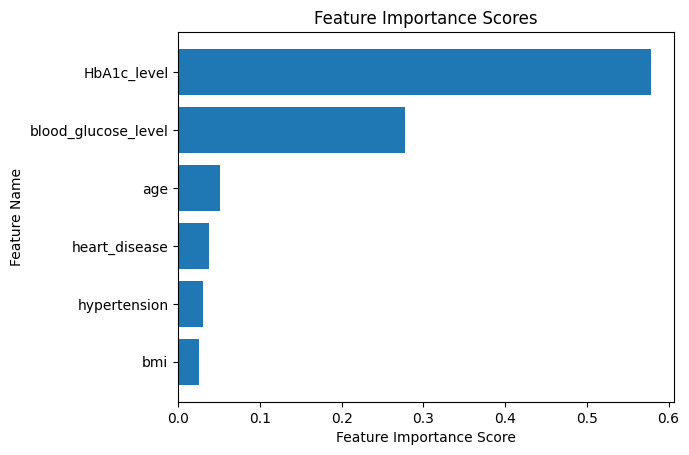

In [11]:
importance_scores = xgb_clf_best.feature_importances_
feature_names = xgb_clf_best.get_booster().feature_names

# Create a dictionary with feature names as keys and their importance scores as values
importance_dict = dict(zip(feature_names, importance_scores))

# Sort the dictionary by importance score in descending order
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=False))


plt.barh(range(len(sorted_importance_dict)), list(sorted_importance_dict.values()), align='center')
plt.yticks(range(len(sorted_importance_dict)), list(sorted_importance_dict.keys()))
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance Scores')
plt.show()